# Import df

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from xgboost import plot_tree

In [127]:
df = pd.read_parquet('../data/cleanedData/allData.parquet')
df.set_index('measurementDate', inplace=True)
df.dropna(inplace=True)



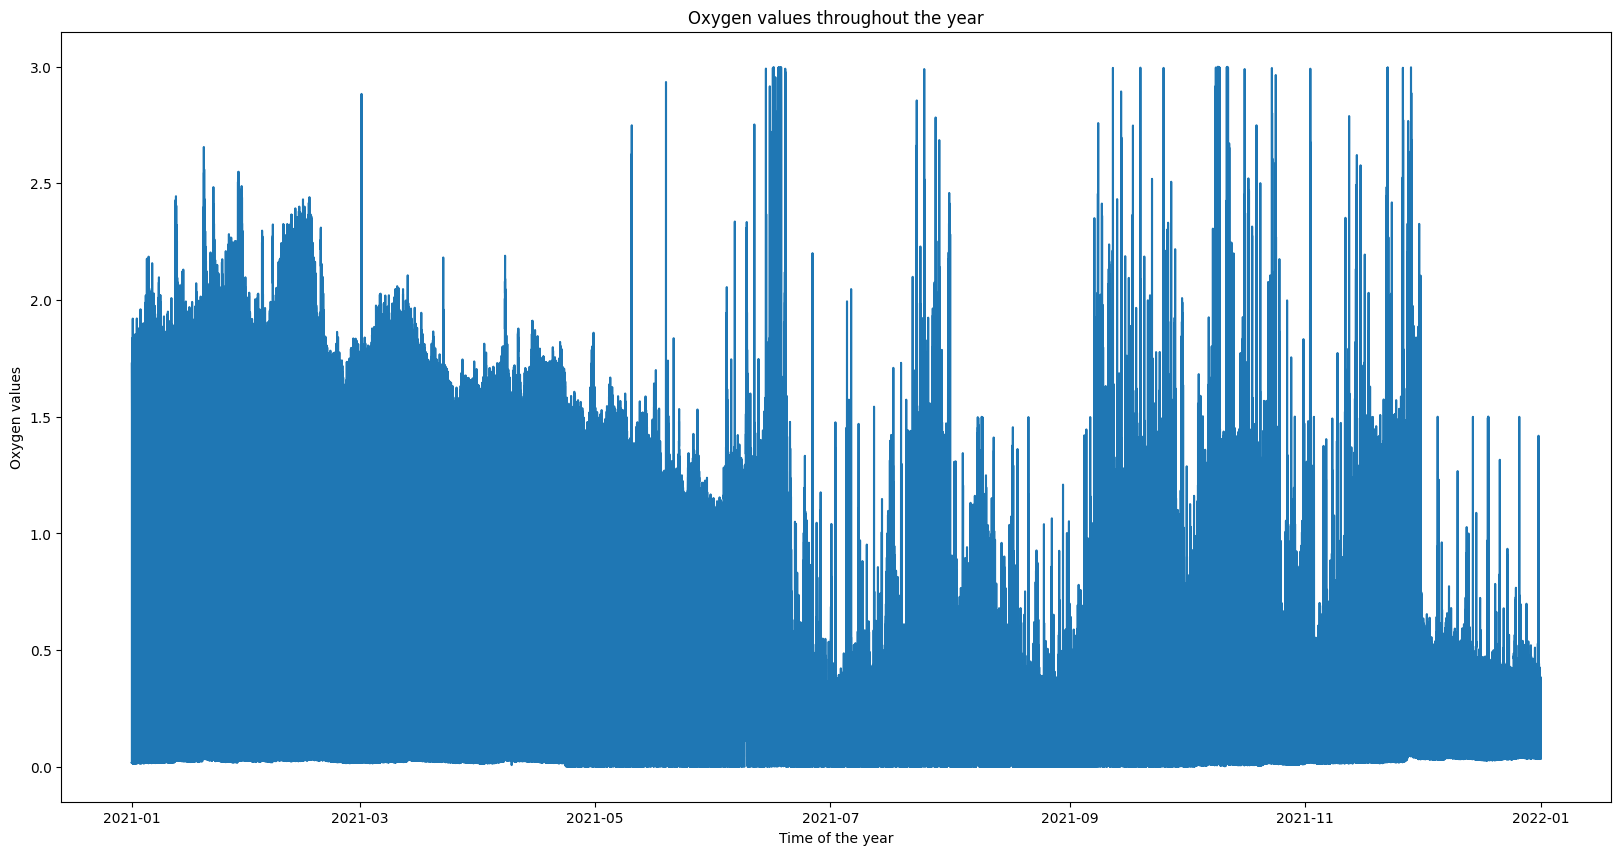

In [128]:
plt.figure(figsize=(20,10))
plt.plot(df.index, df['oxygenValue'])
plt.title("Oxygen values throughout the year")
plt.xlabel("Time of the year")
plt.ylabel("Oxygen values")
plt.show()

# ! Time test Split !

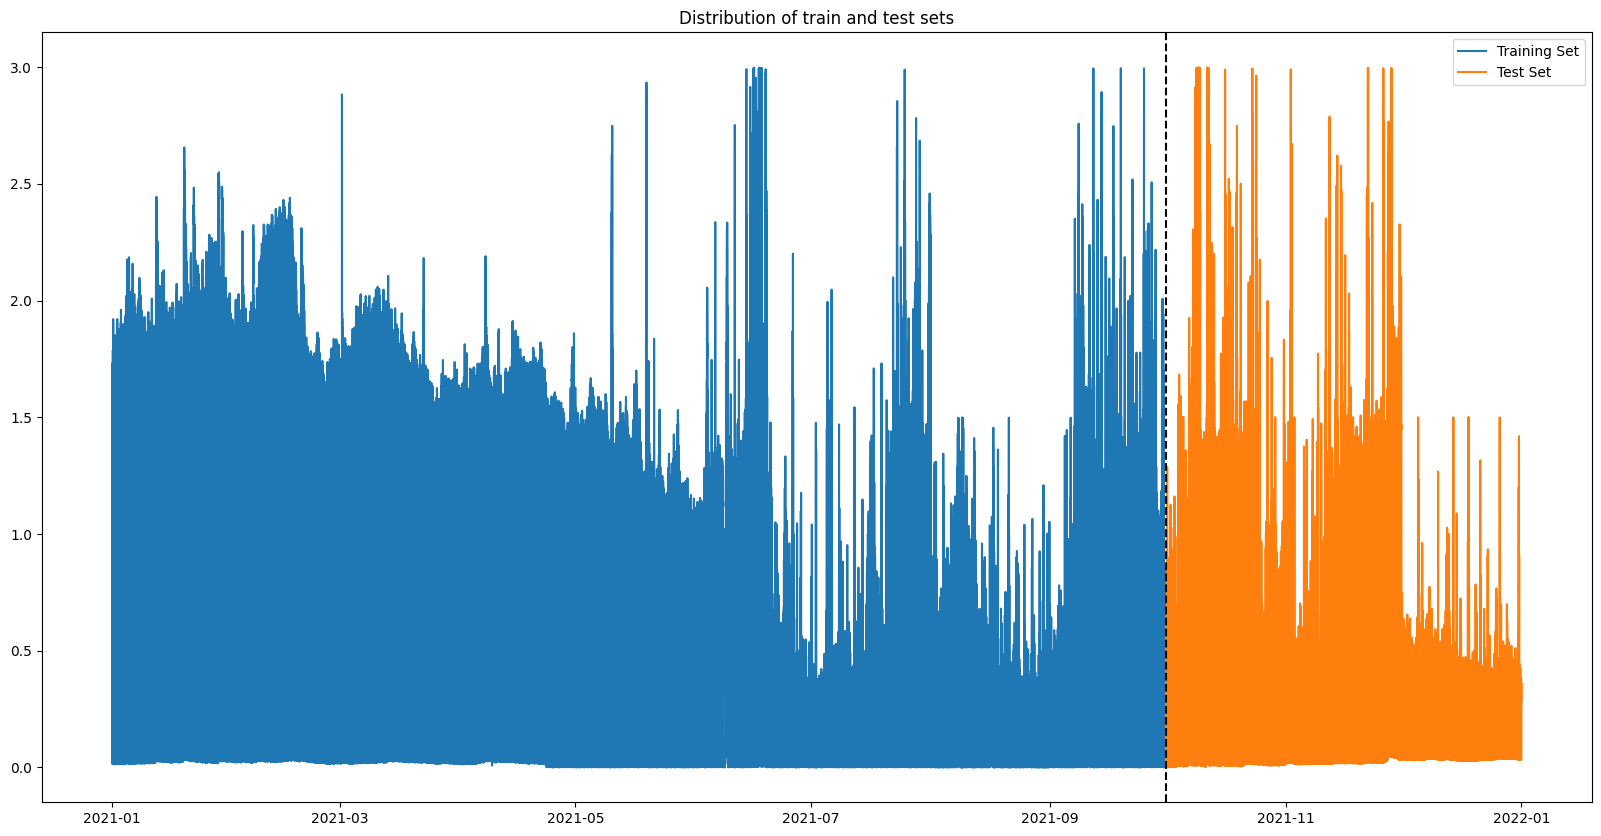

In [129]:
train = df.loc[df.index<'2021-10-01']
test = df.loc[df.index>='2021-10-01']

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train.index,train['oxygenValue'])
plt.plot(test.index,test['oxygenValue'])
ax.axvline(pd.to_datetime('2021-10-01'),color='black', ls='--')
plt.title("Distribution of train and test sets")
plt.legend(['Training Set','Test Set'])
plt.show()

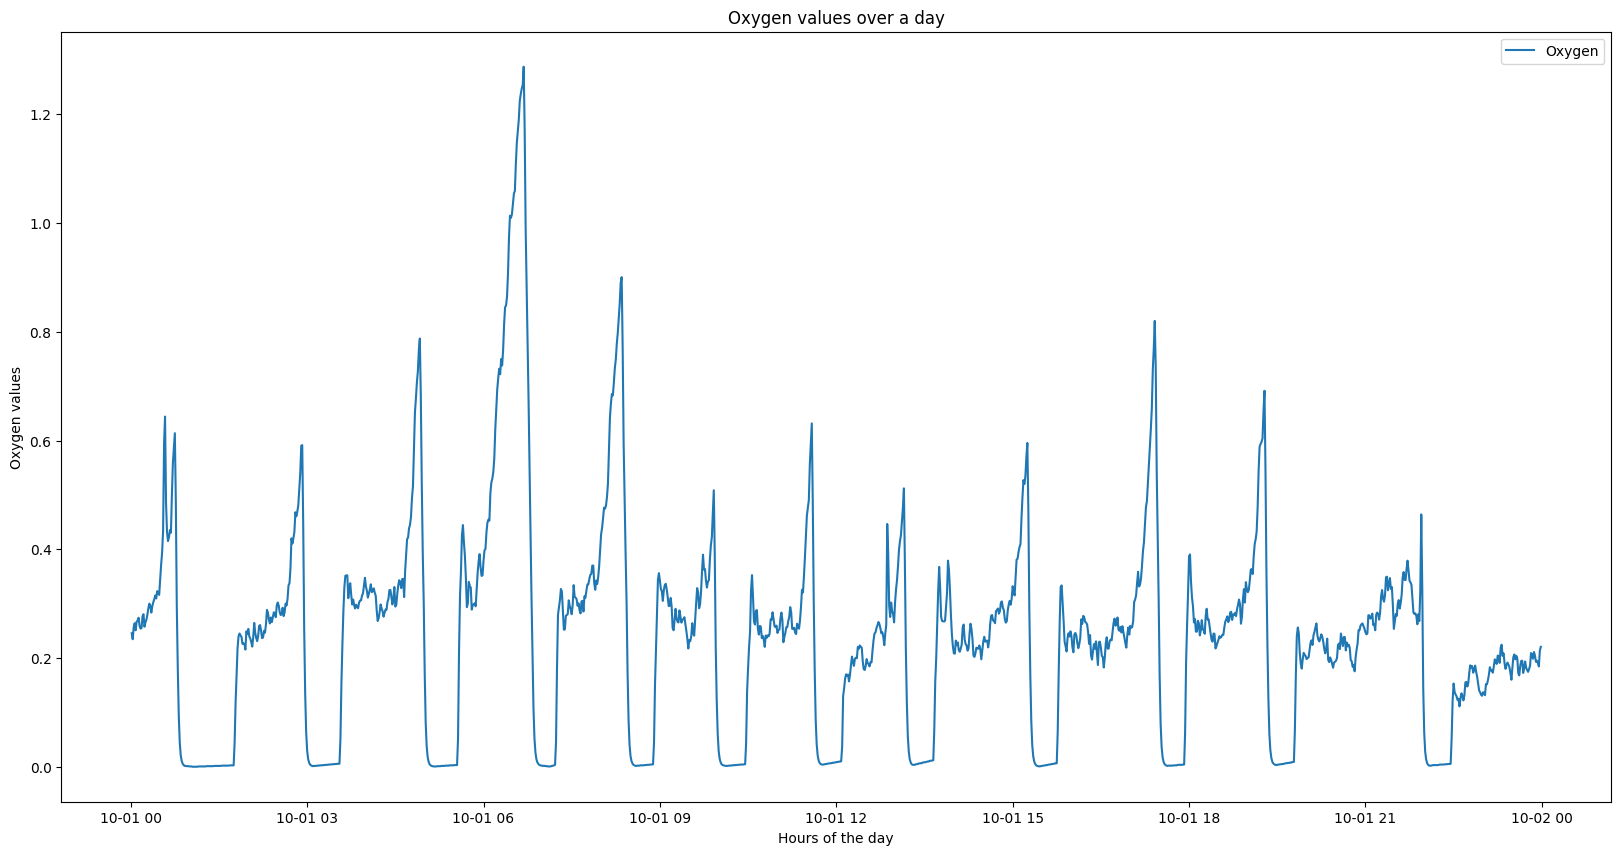

In [130]:
day = df.loc[(df.index > '2021-10-01') & (df.index < '2021-10-02')]

plt.figure(figsize=(20,10))
plt.title("Oxygen values over a day")
plt.plot(day.index,day['oxygenValue'])
plt.xlabel('Hours of the day')
plt.ylabel('Oxygen values')
plt.legend(["Oxygen"])

# Feature Creation

In [131]:
def create_features(df):
    df = df.copy()
    df['minute'] =df.index.minute
    df['hour'] = df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    return df

df = create_features(df)
df['oxygenValue']

measurementDate
2021-01-01 00:01:00    0.0160
2021-01-01 00:02:00    0.0155
2021-01-01 00:03:00    0.0155
2021-01-01 00:04:00    0.0155
2021-01-01 00:05:00    0.0155
                        ...  
2021-12-31 23:55:00    0.2760
2021-12-31 23:56:00    0.2745
2021-12-31 23:57:00    0.2795
2021-12-31 23:58:00    0.2770
2021-12-31 23:59:00    0.2840
Name: oxygenValue, Length: 525347, dtype: float64

Text(0, 0.5, 'Value of oxygen')

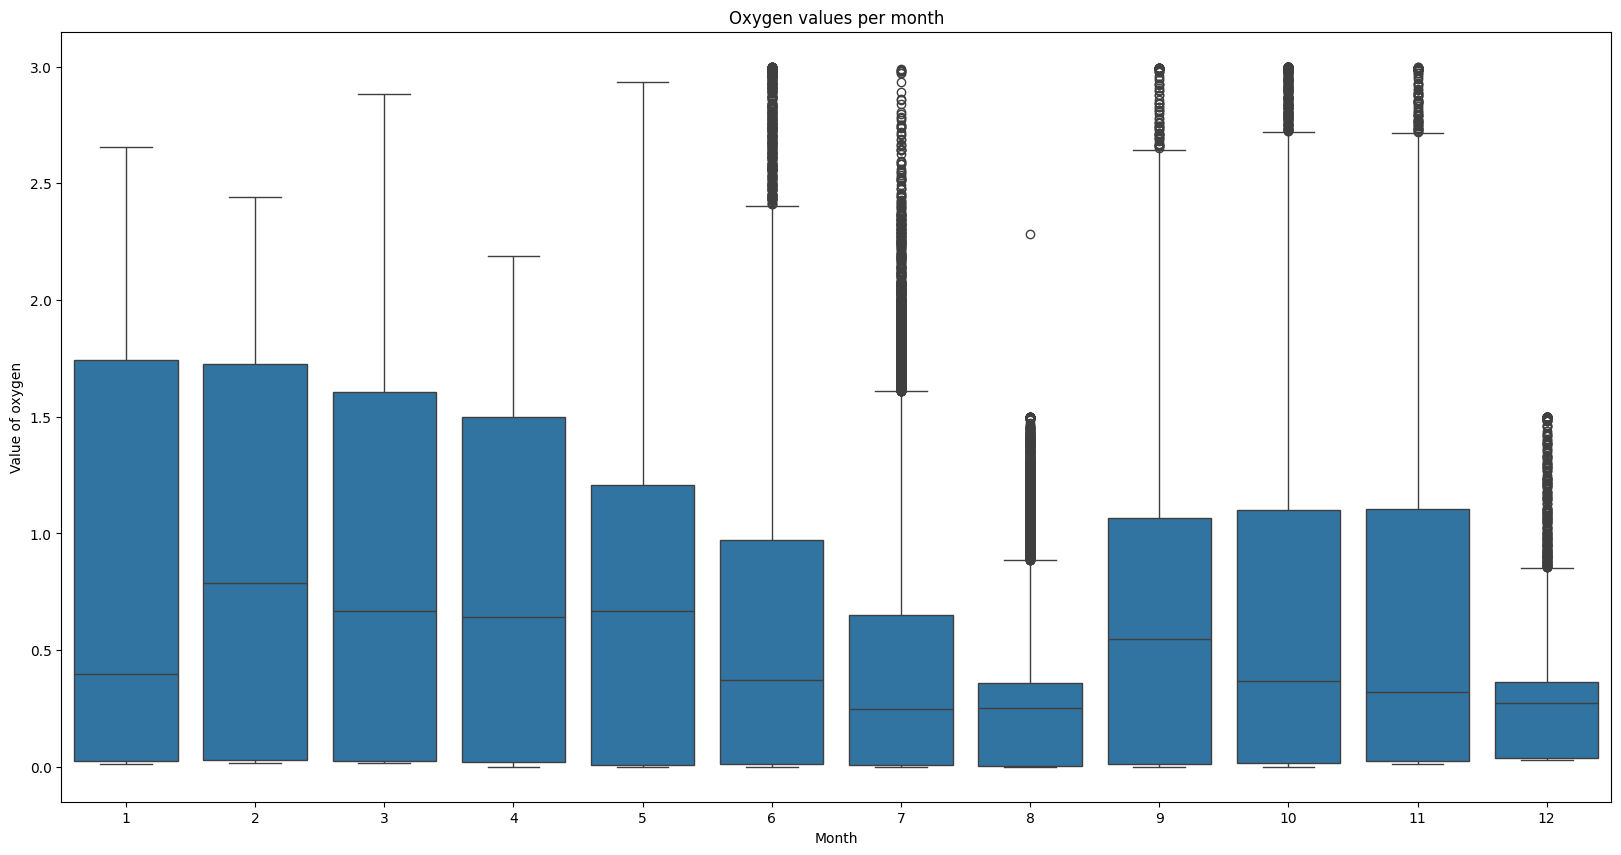

In [132]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,x='month', y='oxygenValue') 
plt.title('Oxygen values per month')
plt.xlabel("Month")
plt.ylabel("Value of oxygen")

# Distribution across periods

Text(0, 0.5, 'Value of oxygen')

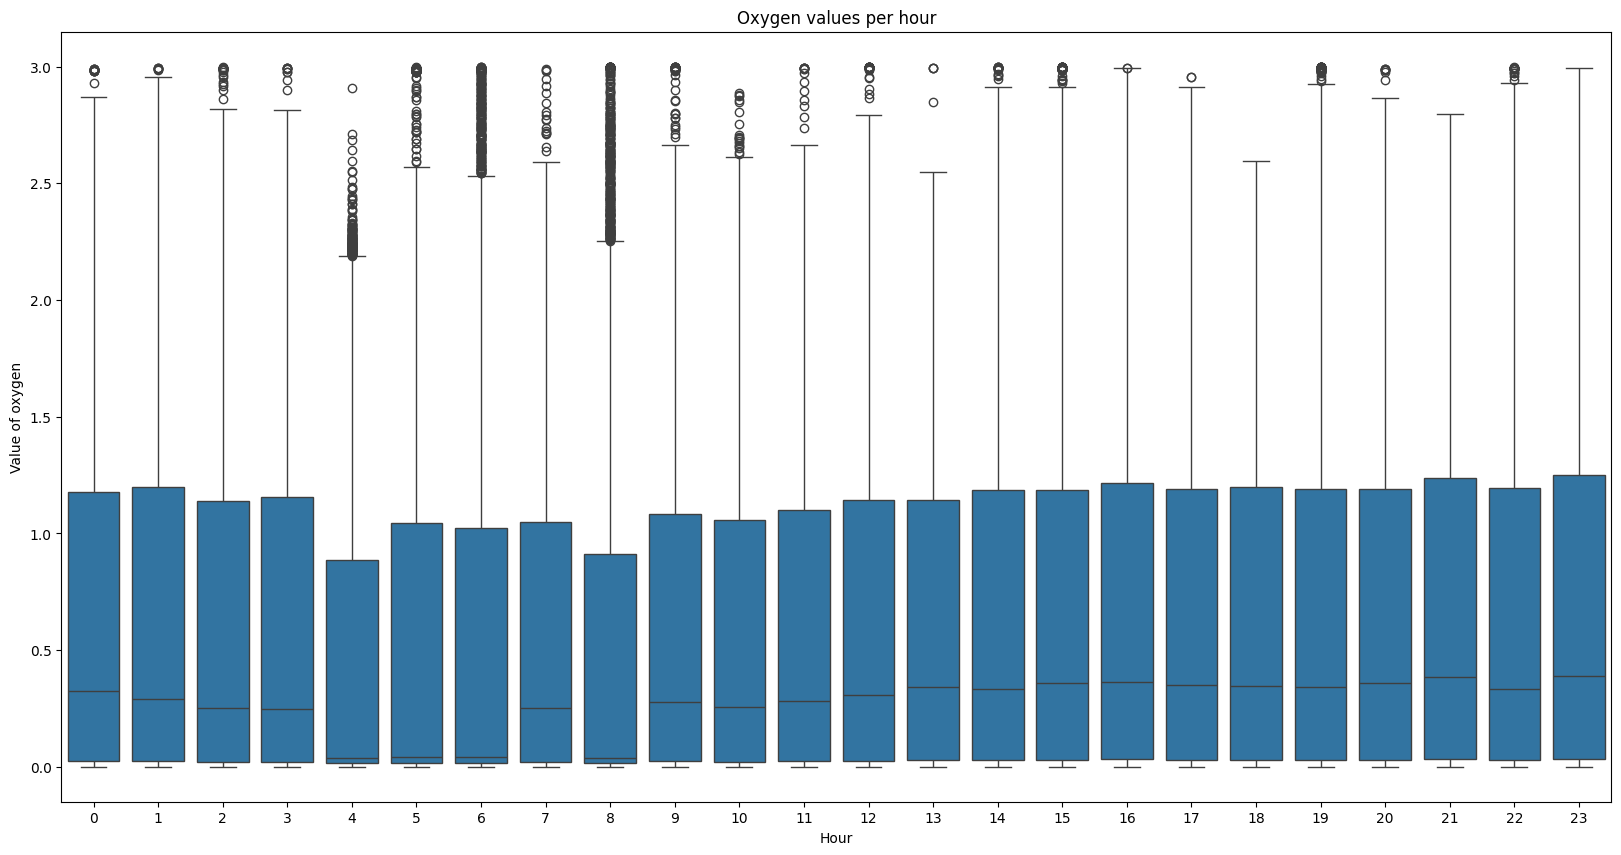

In [133]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,x='hour',y='oxygenValue')
plt.title('Oxygen values per hour')
plt.xlabel("Hour")
plt.ylabel("Value of oxygen")

Text(0, 0.5, 'Value of oxygen')

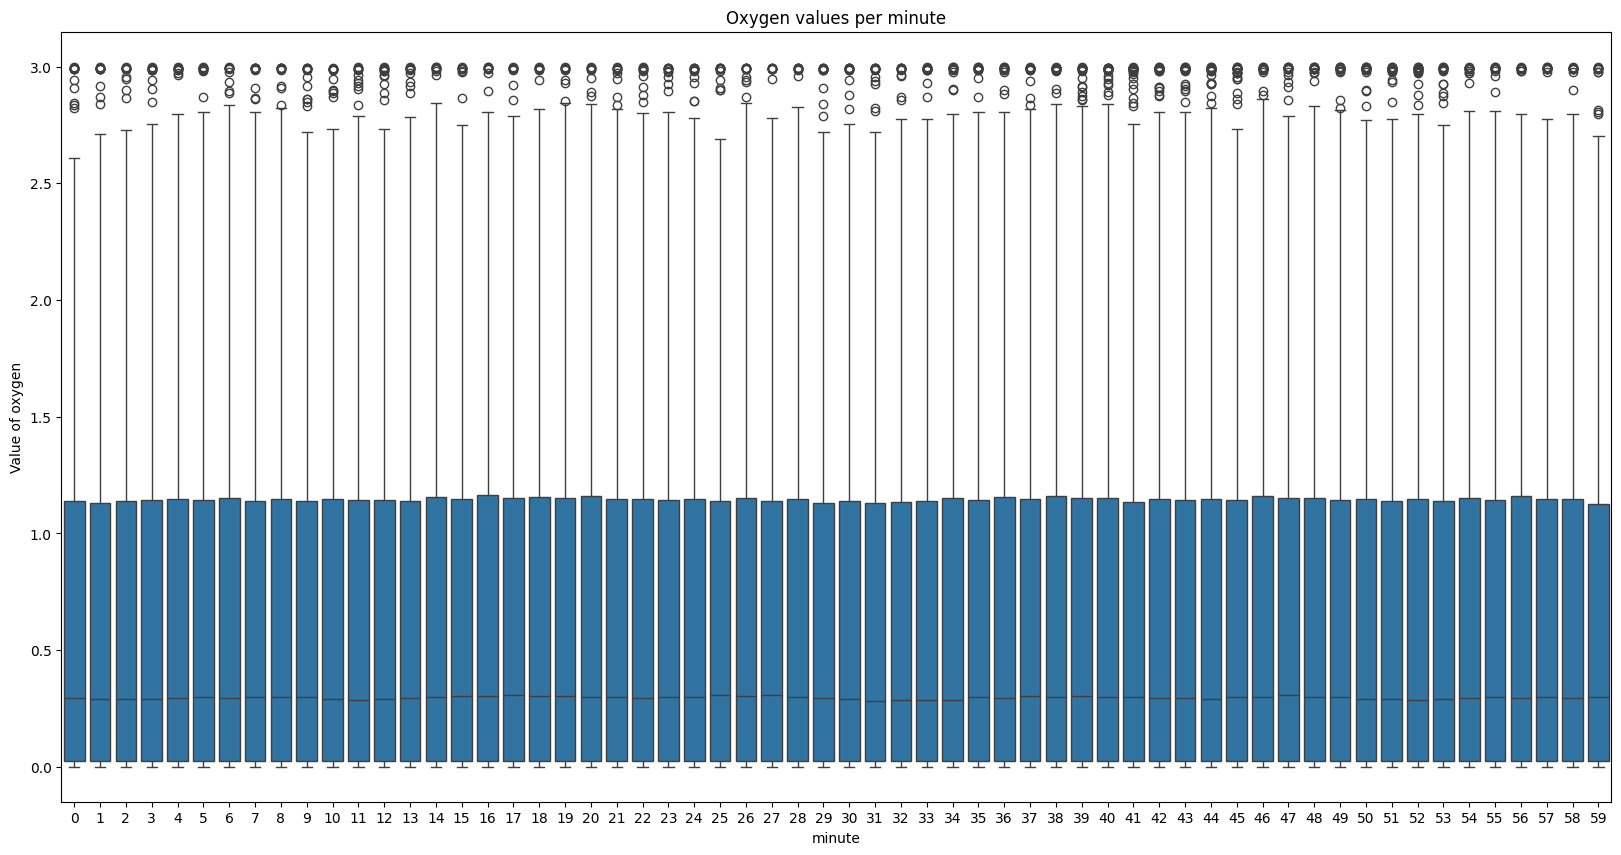

In [134]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,x='minute',y='oxygenValue')
plt.title('Oxygen values per minute')
plt.xlabel("minute")
plt.ylabel("Value of oxygen")

# Lag Features

In [135]:
target_map = df['oxygenValue'].to_dict()

In [136]:
def add_lags(df):
    df['lag_1']=(df.index - pd.Timedelta('1 day')).map(target_map)
    df['lag_2']=(df.index - pd.Timedelta('2 day')).map(target_map)
    df['lag_3']=(df.index - pd.Timedelta('3 day')).map(target_map)
    return df

In [137]:
df= add_lags(df)

# Creating a model

In [138]:
train = create_features(train)
test = create_features(test)

In [139]:
FEATURES = ['nitrateValue', 'phosphateValue', 'ammoniumValue',
       'waterFlowPerMinute', 'precipitation', 'minute', 'hour', 'dayofweek',
       'quarter', 'month']
TARGET = 'oxygenValue'

In [140]:
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

In [141]:

paramsRF = {
  "colsample_bynode": 0.9,
  "learning_rate":0.8,
  "max_depth": 9,
  "num_parallel_tree": 150,
  "objective": "reg:squarederror",
  "subsample": 0.9,
  "tree_method": "hist",
  "device": "cuda"
}

reg = xgb.XGBRFRegressor(**paramsRF)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:0.53256	validation_1-rmse:0.54956


XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=0.9,
               colsample_bytree=None, device='cuda', early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.8, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=150, objective='reg:squarederror', ...)

# Feature importance

In [142]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])


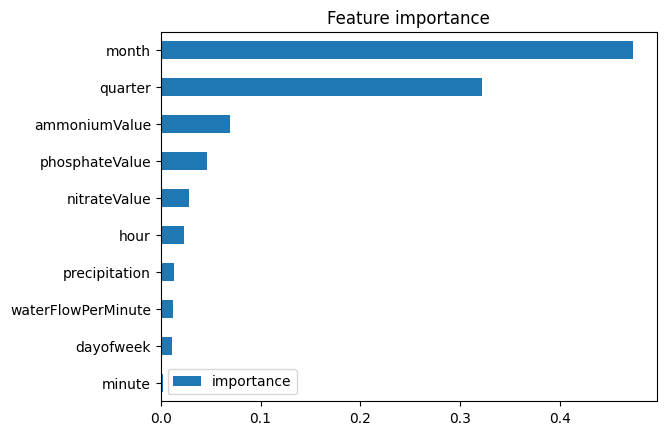

In [143]:
fi.sort_values('importance').plot(kind='barh', title="Feature importance")
plt.show()

In [144]:
test['prediction']=reg.predict(X_test)
df= df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.194435 to fit


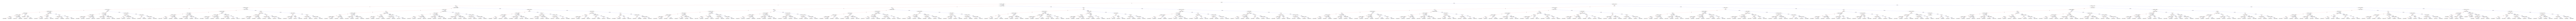

In [145]:
plot_tree(reg)
fig = plt.gcf()
fig.set_size_inches(160, 600)
#fig.savefig('tree.png')
plt.show()

# Prediction

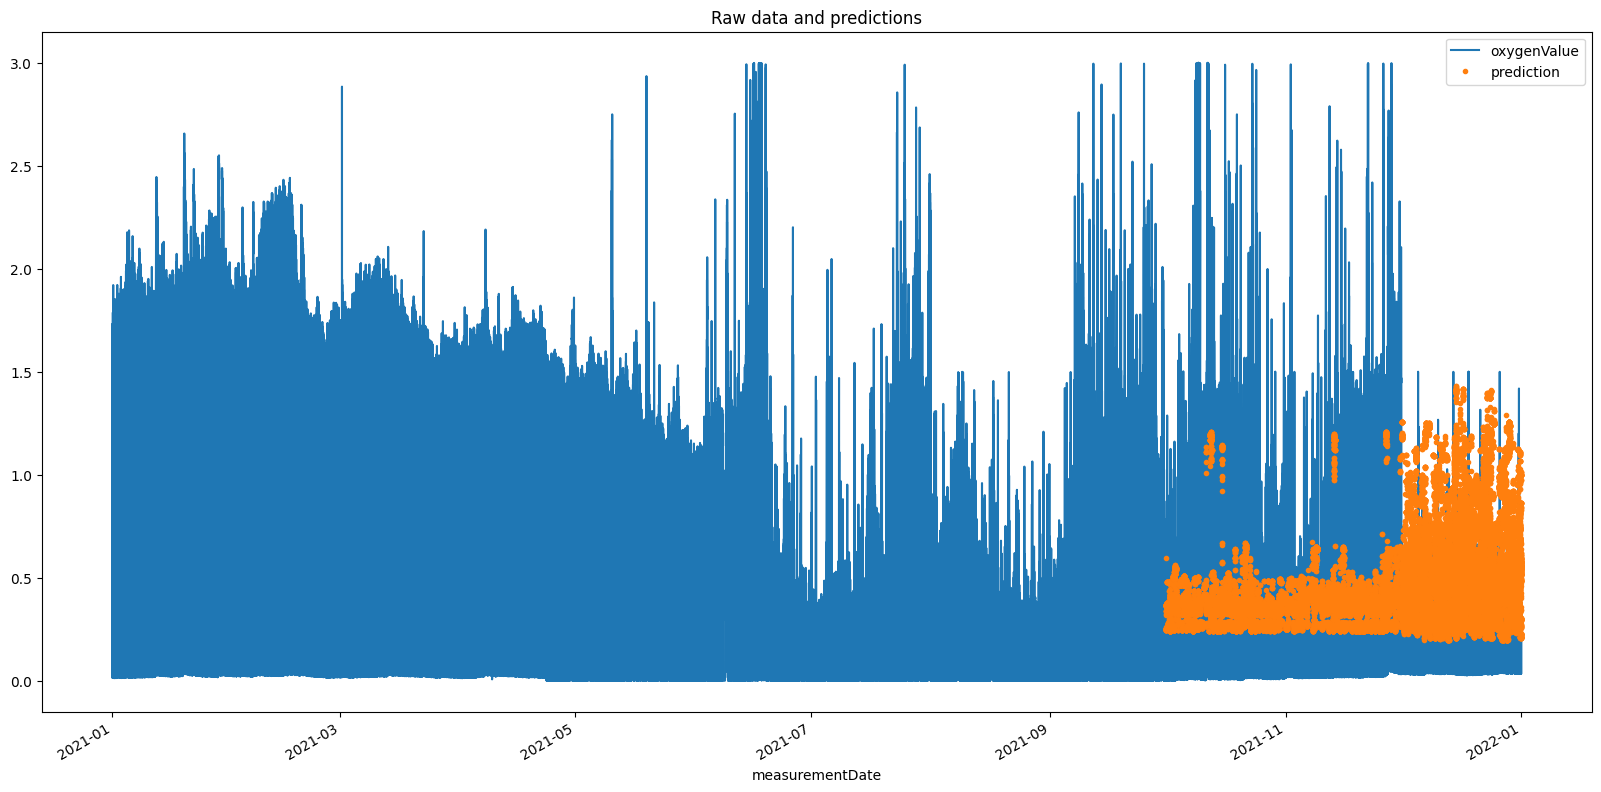

In [146]:
ax = df[['oxygenValue']].plot(figsize=(20,10))
df['prediction'].plot(ax=ax,style='.')
plt.legend()
ax.set_title('Raw data and predictions')
plt.show()

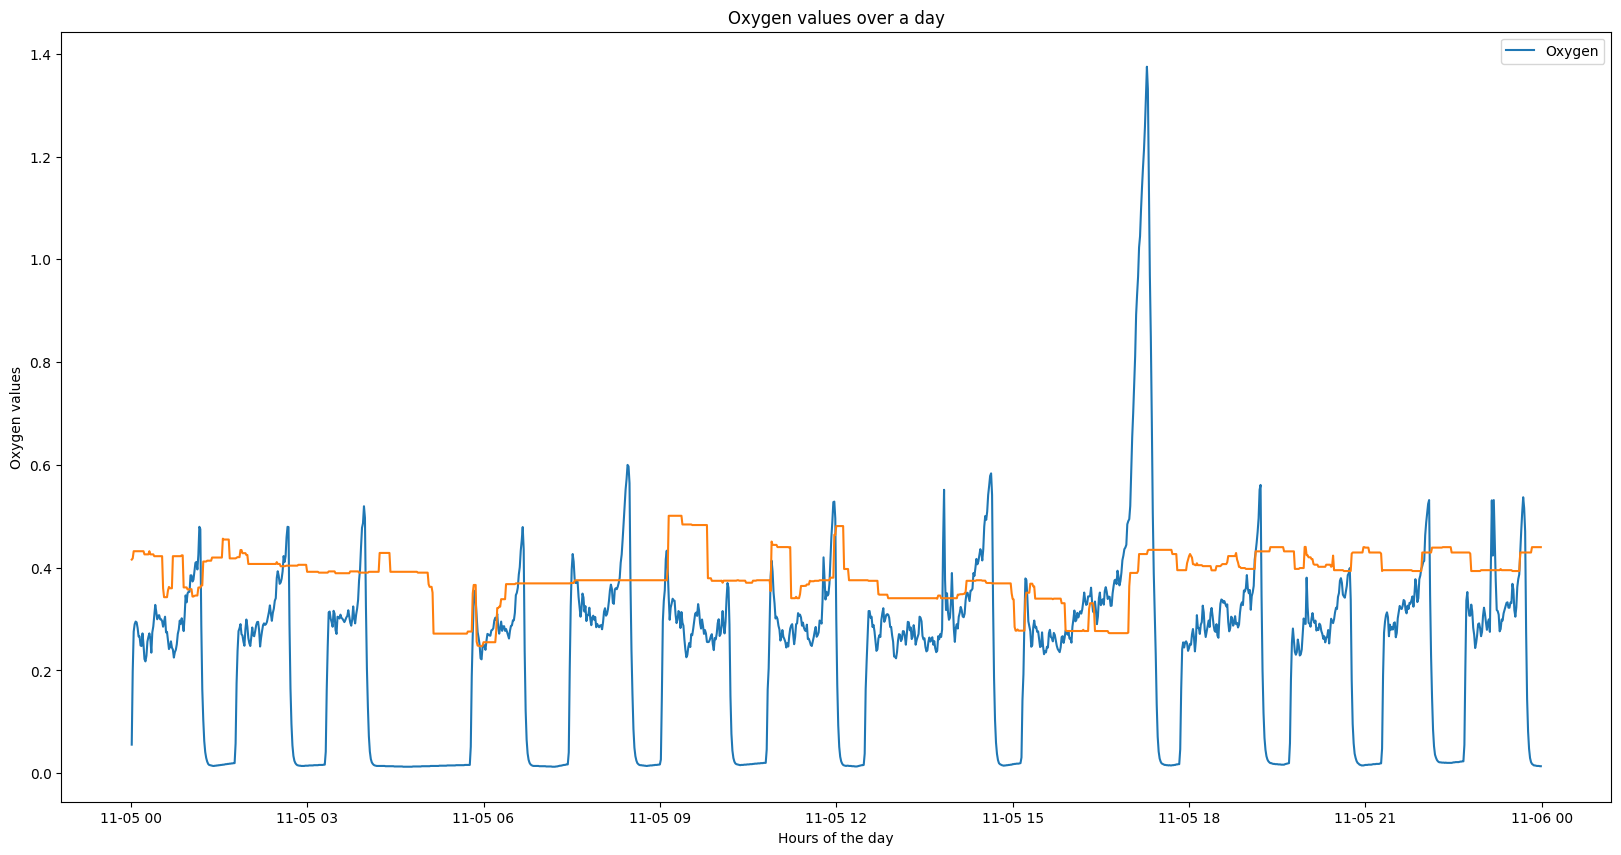

In [147]:
day = df.loc[(df.index > '2021-11-05') & (df.index < '2021-11-06')]

plt.figure(figsize=(20,10))
plt.title("Oxygen values over a day")
plt.plot(day.index,day['oxygenValue'])
plt.plot(day.index,day['prediction'])
plt.xlabel('Hours of the day')
plt.ylabel('Oxygen values')
plt.legend(["Oxygen"])

In [148]:
print(f"The model's Root Mean Squared Error: {root_mean_squared_error(test['oxygenValue'],test['prediction'])}")

The model's Root Mean Squared Error: 0.5495586905427444
